# Lab 6: Exploring classification II

In Lab 5 we explored the basics of classification. Specifically we: 

- Visualised the **decision regions** and **boundaries** of linear classifiers.
- Implemented **linear classifiers**.
- Computed the **accuracy** of the implemented classifiers.

We also took the opportunity to see **gradient descent** in action in the context of logistic regression. We visualised the corresponding **error surface** and plotted the sequence of models produced by gradient descent until reaching the **optimal model**.

In general we won't be able to visualise our datasets and error surfaces in the same way, as the predictor space will have a high dimensionality (i.e. there will be many predictors). Even though we won't be able to visualise decision regions in a 10D or 200D space, decision regions still exist and our methods will work in exactly the same way. The trick is to understand and carry out all our mental experiments in low-dimensional spaces, and then assume everything works in the same way in high-dimensional spaces.

In this lab we will use the well-known Iris dataset to build and analyse the performance of multi-class classifiers. We will first consider a **kNN** classifier and analyse the impact of changing the value of k on the resulting decision regions. We will then train a **logistic regression** classifier and will analyse its performance using the **confusion matrix**. Finally, we will implement a **Bayesian approach** with Gaussian class densities.


# The Iris dataset

The Iris flower dataset is a classic dataset used to identify three flower species based on features describing their [sepals](https://en.wikipedia.org/wiki/Sepalhttps://) and [petals](https://en.wikipedia.org/wiki/Petal). Let's load it first and print its description.

In [1]:
import numpy as np
from sklearn import datasets

iris = datasets.load_iris()

print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

As read in the description, the Iris dataset consists of 150 samples described by 5 attributes. Four of them will be used used as predictors (the flowers' features) and the fifth one will be used as a discrete label. 

The predictors are:
- Sepal length.
- Sepal width.
- Petal length. 
- Petal width.

The label can take on three different values, in other words, there are three classes in the Iris dataset, which are:
- Setosa.
- Versicolor.
- Virginica.

Each class corresponds to a different flower species. Hence, the Iris dataset can be used to build machine learning models that identify one of these flowers species by looking at the 4 features describing their petals and sepals. 


Let's load the predictors and label into two separate NumPy arrays `x_iris` and `y_iris` and check their shape:

In [2]:
x_iris = iris.data
y_iris = iris.target

print("The shape of the NumPy array x_iris containing the predictors is:", x_iris.shape)
print("The shape of the NumPy array y_iris containing the label is:",y_iris.shape)

The shape of the NumPy array x_iris containing the predictors is: (150, 4)
The shape of the NumPy array y_iris containing the label is: (150,)


In this lab, we will use the first two predictors (sepal length and sepal width), as we can easily visualise 2D predictors space. Let's store the two predictors in a new NumPy array:

In [3]:
x_iris_sepal = iris.data[:, :2] 

print("The first two predictors are", iris.feature_names[:2])
print("The shape of the NumPy array x_iris_sepal containing the first two pre predictors is", x_iris_sepal.shape)

The first two predictors are ['sepal length (cm)', 'sepal width (cm)']
The shape of the NumPy array x_iris_sepal containing the first two pre predictors is (150, 2)


As expected, the shape of the NumPy array `x_iris_sepal` is `(150, 2)`, which means there are 150 samples desribed by 2 predictors. 

Let's plot the dataset in the predictor space. We will use 3 different symbols to represent each of the 3 different values that the label `y_iris` can take on, namely 0 (setosa), 1 (versicolor) and 2 (virginica).

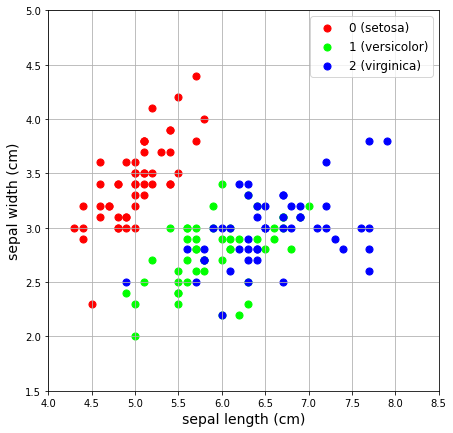

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

scatter = plt.scatter(x_iris_sepal[y_iris==0,0], x_iris_sepal[y_iris==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, iris.target_names[0]))
scatter = plt.scatter(x_iris_sepal[y_iris==1,0], x_iris_sepal[y_iris==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, iris.target_names[1]))
scatter = plt.scatter(x_iris_sepal[y_iris==2,0], x_iris_sepal[y_iris==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, iris.target_names[2]))

plt.legend(fontsize=12)
plt.xlabel(iris.feature_names[0], fontsize=14)
plt.ylabel(iris.feature_names[1], fontsize=14)
plt.xlim(4,8.5)
plt.ylim(1.5,5)
plt.grid(True)
plt.show()

Plotting the dataset in the predictor space reveals that the three classes are not linearly separable, i.e. we cannot create straight boundaries in the predictor space that separate samples from different classes. Can you visualise a non-linear boundary capable of separating the three classes? 


Let's split the dataset into a training dataset and a validation dataset that we will use to assess the deployent performance of our models. In general we will need to carefully determine how many samples should be used for training and for validation. However for the purpose of this lab, let's assume that 75 samples are sufficient for training and validation purposes. After splitting, let's plot the training and validation datasets.

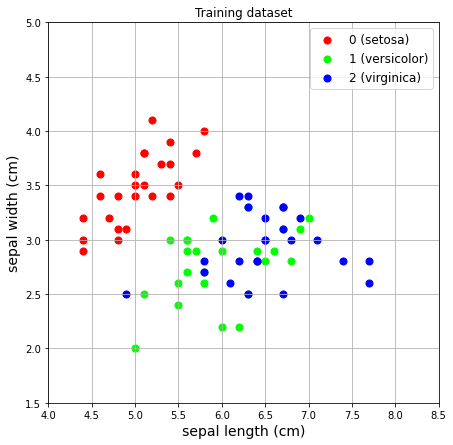

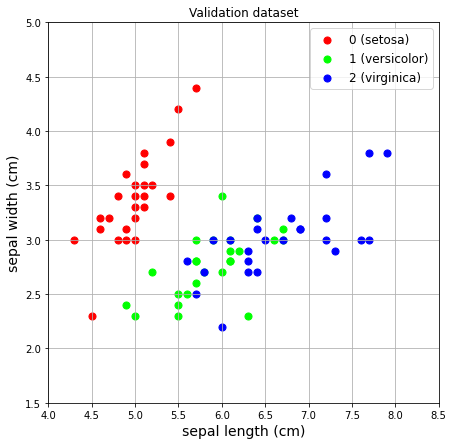

In [5]:

# Here we split our dataset into training and validation datasets
x_train = x_iris_sepal[::2,:] # train data set (both predictors)
y_train = y_iris[::2] # train data set (labels)
x_val = x_iris_sepal[1::2,:] # test data set (both predictors)
y_val = y_iris[1::2] # test data set (labels)


# The rest of this cell is used to plot the training and validation datasets
plt.figure(figsize=(7, 7))

scatter = plt.scatter(x_train[y_train==0,0], x_train[y_train==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, iris.target_names[0]))
scatter = plt.scatter(x_train[y_train==1,0], x_train[y_train==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, iris.target_names[1]))
scatter = plt.scatter(x_train[y_train==2,0], x_train[y_train==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, iris.target_names[2]))

plt.title("Training dataset")
plt.legend(fontsize=12)
plt.xlabel(iris.feature_names[0], fontsize=14)
plt.ylabel(iris.feature_names[1], fontsize=14)
plt.xlim(4,8.5)
plt.ylim(1.5,5)
plt.grid(True)

plt.figure(figsize=(7, 7))

scatter = plt.scatter(x_val[y_val==0,0], x_val[y_val==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, iris.target_names[0]))
scatter = plt.scatter(x_val[y_val==1,0], x_val[y_val==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, iris.target_names[1]))
scatter = plt.scatter(x_val[y_val==2,0], x_val[y_val==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, iris.target_names[2]))

plt.title("Validation dataset")
plt.legend(fontsize=12)
plt.xlabel(iris.feature_names[0], fontsize=14)
plt.ylabel(iris.feature_names[1], fontsize=14)
plt.xlim(4,8.5)
plt.ylim(1.5,5)
plt.grid(True)
plt.show()

# kNN classifiers

The k nearest neighbours (kNN) algorithm is an instance-based method that assigns a new sample to the **majotiry class** amongst the k closest training samples. From a statistical point of view, we can see kNN as a method that creates **posterior probabilities** by identifying the closest training samples and obtaining the fraction of samples belonging to each class.

We could easily implement kNN ourselves, however we will use the implementation provided by the [scikit-learn](https://scikit-learn.org/stable/) library. The scikit library is the most important Python library for machine learning and also a good place to learn and try new machine learning methods. 

In the cell below we will create several kNN classifiers for different values of k, will show the resulting decision regions and finally will obtain their validation accuracy. Note that k shouldn't be seen as a parameter of our model, but rather as a **hyperparameter**. In machine learning parameters are adjusted (for instance the intercept and slope of a straight line), while hyperparameters define families of models that behave very differently (in polynomial regression, the polynomial degree is a hyperparameter). The kNN algorithm is a strange one, in that there are **no parameters to adjust** and there is one hyperparameter.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The validation accuracy for k= 1 is  0.68


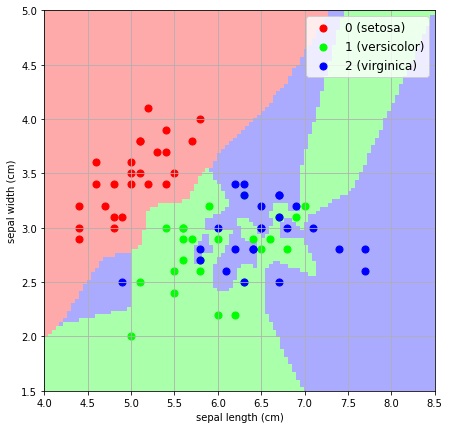

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The validation accuracy for k= 7 is  0.7733333333333333


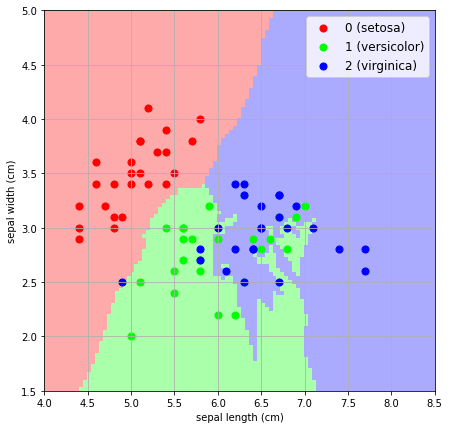

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The validation accuracy for k= 13 is  0.7866666666666666


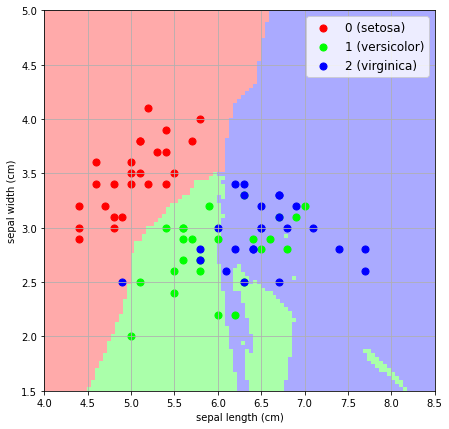

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The validation accuracy for k= 19 is  0.8


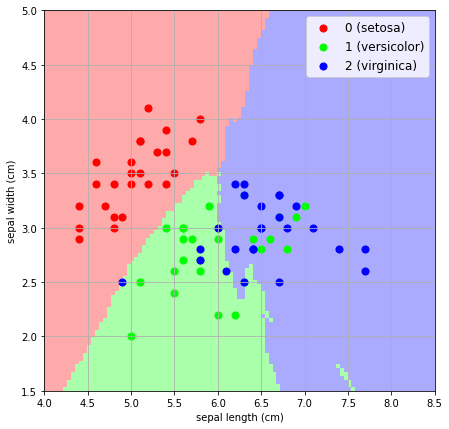

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The validation accuracy for k= 25 is  0.84


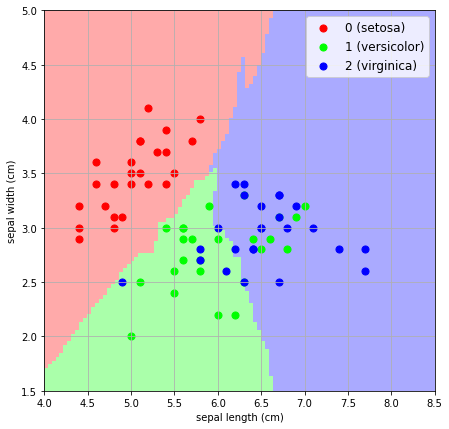

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The validation accuracy for k= 31 is  0.8266666666666667


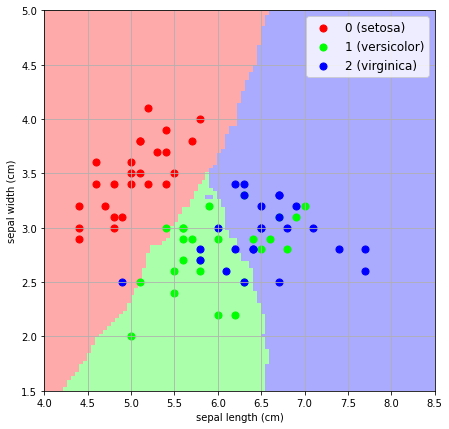

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The validation accuracy for k= 37 is  0.8133333333333334


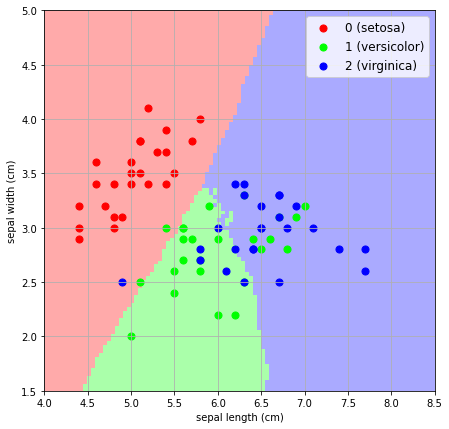

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The validation accuracy for k= 43 is  0.76


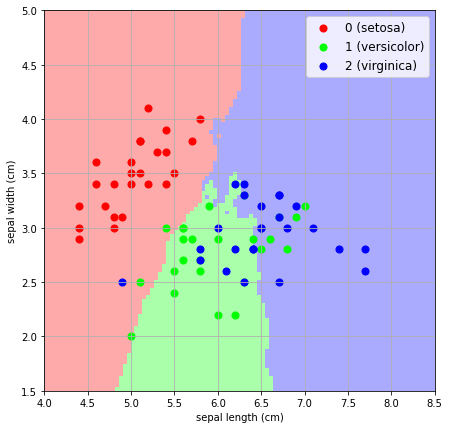

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The validation accuracy for k= 49 is  0.7333333333333333


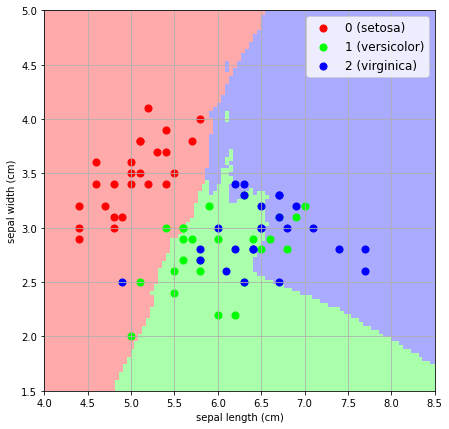

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The validation accuracy for k= 55 is  0.7733333333333333


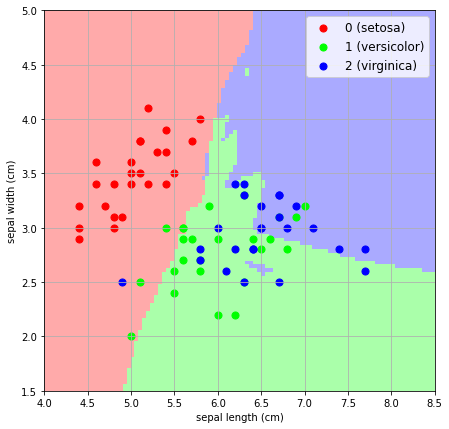

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The validation accuracy for k= 61 is  0.7066666666666667


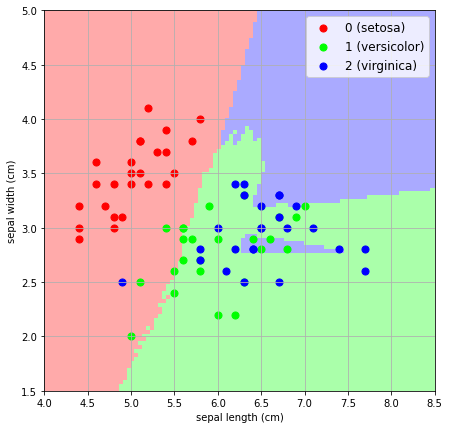

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The validation accuracy for k= 67 is  0.6933333333333334


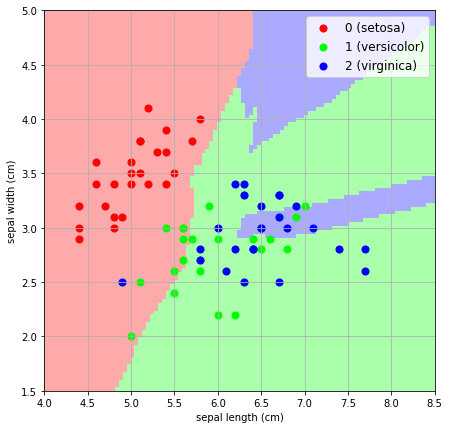

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The validation accuracy for k= 73 is  0.4666666666666667


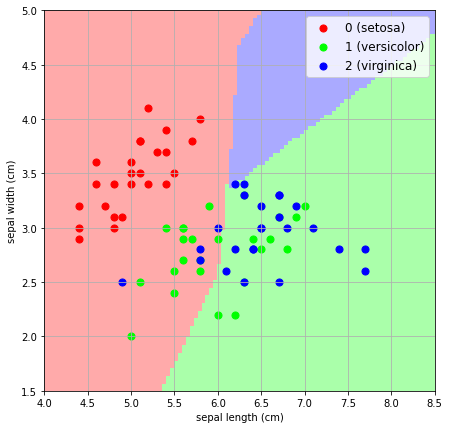

<IPython.core.display.Javascript object>

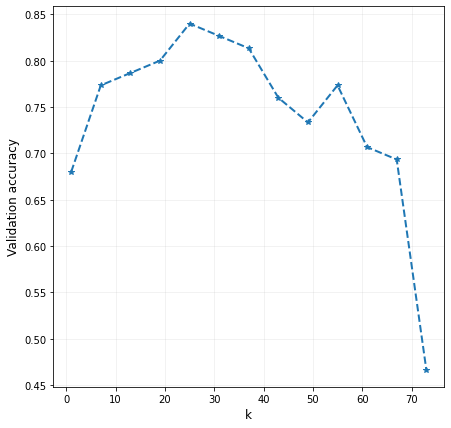

In [6]:
from google.colab import widgets
from sklearn import neighbors
from matplotlib.colors import ListedColormap

k_values = range(1,75,6)
tb = widgets.TabBar([str(k) for k in k_values])

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

accuracy = dict.fromkeys(k_values)

for k in k_values:
    with tb.output_to(str(k), select= (k < 2)):

        # First we create the kNN model
        knn = neighbors.KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train)

        # Now we plot its decision regions
        coor1 = np.linspace(4, 8.5, 100)
        coor2 = np.linspace(1.5, 5, 100)
        x1_mesh, x2_mesh = np.meshgrid(coor1, coor2)
        yPred = knn.predict(np.c_[x1_mesh.ravel(), x2_mesh.ravel()])
        yPred = yPred.reshape(x2_mesh.shape)
        plt.figure(figsize=(7, 7))
        plt.pcolormesh(x1_mesh, x2_mesh, yPred, cmap=cmap_light)

        # Here we plot the training dataset
        scatter = plt.scatter(x_train[y_train==0,0], x_train[y_train==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, iris.target_names[0]))
        scatter = plt.scatter(x_train[y_train==1,0], x_train[y_train==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, iris.target_names[1]))
        scatter = plt.scatter(x_train[y_train==2,0], x_train[y_train==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, iris.target_names[2]))

        plt.xlabel('sepal length (cm)')
        plt.ylabel('sepal width (cm)')
        plt.legend(fontsize=12)
        plt.xlim(4,8.5)
        plt.ylim(1.5,5)
        plt.grid(True)


        # Finally we calculate the validation accuracy
        y_val_pred = knn.predict(x_val)
        accuracy[k] = np.sum(y_val==y_val_pred)/len(y_val)

        print("The validation accuracy for k=", k, "is ", accuracy[k])


# Here we predict the value of the validation accuracy as a function of k
plt.figure(figsize=(7, 7))
plt.plot(k_values, list(accuracy.values()), '--*', linewidth=2)
plt.xlabel("k", fontsize=12)
plt.ylabel("Validation accuracy", fontsize=12)
plt.grid(alpha=0.2)
plt.show()

Do the decision regions make sense to you? Note how the complexity of the decision boundaries and the validation accuracy change as we increase the value of the hyperparamenter k. Based on this simple validation approach, which value of k would you select? 

If you were to calculate the **training accuracy** for k=1, the result would be 1. Do you see why? Will the training accuracy be also 1 for other values of k?

# Logistic regression linear classifier

In Lab 5 we implemented a logistic regression binary classifier by ourseleves. In this section we will import the implementation available from the scikit-learn library. Remember that in this lab we are considering a multi-class (specifically 3-class) scenario. We will however not discuss the extension of logistic regression to multi-class scenarios, just remember that we will be producing linear boundaries and that the closer a sample is to the linear boundary, the higher the classifier's uncertainty.


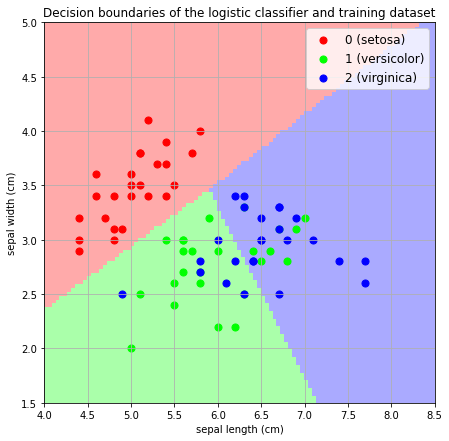

Training accuracy of the logistic classifier: 0.8


In [7]:
from sklearn.linear_model import LogisticRegression

# Here we fit our logistic regression classfier to the training dataset 
log_reg_classifier = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
log_reg_classifier.fit(x_train, y_train)

# Here we plot the decision regions of our dataset
coor1 = np.linspace(4, 8.5, 100)
coor2 = np.linspace(1.5, 5, 100)
x1_mesh, x2_mesh = np.meshgrid(coor1, coor2)

yPred = log_reg_classifier.predict(np.c_[x1_mesh.ravel(), x2_mesh.ravel()])
yPred = yPred.reshape(x2_mesh.shape)

plt.figure(figsize=(7, 7))
plt.pcolormesh(x1_mesh, x2_mesh, yPred, cmap=cmap_light)


# Here we plot the training dataset
scatter = plt.scatter(x_train[y_train==0,0], x_train[y_train==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, iris.target_names[0]))
scatter = plt.scatter(x_train[y_train==1,0], x_train[y_train==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, iris.target_names[1]))
scatter = plt.scatter(x_train[y_train==2,0], x_train[y_train==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, iris.target_names[2]))
plt.title('Decision boundaries of the logistic classifier and training dataset')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend(fontsize=12)
plt.xlim(4,8.5)
plt.ylim(1.5,5)
plt.grid(True)
plt.show()

# Finally we extract and print the accuracy. We can compute the accuracy ourselves, but here we use the score provided by the model itself  
print('Training accuracy of the logistic classifier: {}'.format(log_reg_classifier.score(x_train, y_train)))


To get a visual feeling of how well our model is generalising to unseen data, let's display the validation data together with the decision regions of our classifier. We will also obtain and print the validation accuracy: 

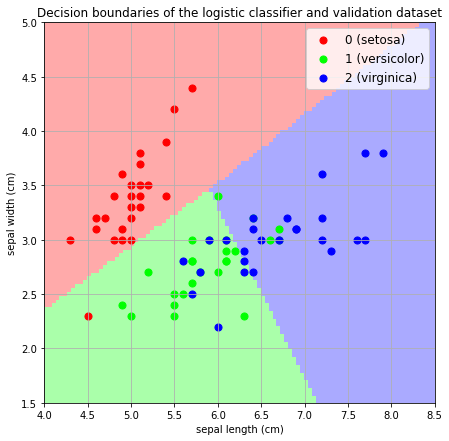

Validation accuracy of the logistic classifier: 0.8266666666666667


In [8]:
plt.figure(figsize=(7, 7))
plt.pcolormesh(x1_mesh, x2_mesh, yPred, cmap=cmap_light)

# Here we plot the validation dataset
scatter = plt.scatter(x_val[y_val==0,0], x_val[y_val==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, iris.target_names[0]))
scatter = plt.scatter(x_val[y_val==1,0], x_val[y_val==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, iris.target_names[1]))
scatter = plt.scatter(x_val[y_val==2,0], x_val[y_val==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, iris.target_names[2]))
plt.title('Decision boundaries of the logistic classifier and validation dataset')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend(fontsize=12)
plt.xlim(4,8.5)
plt.ylim(1.5,5)
plt.grid(True)
plt.show()

print('Validation accuracy of the logistic classifier: {}'.format(log_reg_classifier.score(x_val, y_val)))

Looking at the previous plots, you will have notived that our classifier does a good job with the setosa class, but finds it much harder to classify versicolor and virginica samples. To analyse the performance of our classifier in a class-aware manner, we should look at the **confusion matrix**. Notice that our confusion matrix will be a 3x3 table, as there are 3 classes.

In the next cell, we will obtain the training and test confusion matrices, both as counts and also rates (i.e. normalised). Note that in a the confusion matrices provided by scikit, **rows represent actual classes** and **columns predicted classes**, and that their indices (0, 1 and 2) correspond to each label. 

In [9]:
from sklearn.metrics import confusion_matrix

train_confusion_matrix = confusion_matrix(y_true=y_train, y_pred=log_reg_classifier.predict(x_train))
train_confusion_matrix_normalised = train_confusion_matrix.astype('float') / train_confusion_matrix.sum(axis=1)[:, np.newaxis]

val_confusion_matrix = confusion_matrix(y_true=y_val, y_pred=log_reg_classifier.predict(x_val))
val_confusion_matrix_normalised = val_confusion_matrix.astype('float') / val_confusion_matrix.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(train_confusion_matrix))
print('Validation confusion matrix:\n {}\n'.format(val_confusion_matrix))

print('Normalised training confusion matrix:\n {}\n'.format(train_confusion_matrix_normalised))
print('Normalised validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised))

Training confusion matrix:
 [[25  0  0]
 [ 0 17  8]
 [ 0  7 18]]

Validation confusion matrix:
 [[24  1  0]
 [ 0 20  5]
 [ 0  7 18]]

Normalised training confusion matrix:
 [[1.   0.   0.  ]
 [0.   0.68 0.32]
 [0.   0.28 0.72]]

Normalised validation confusion matrix:
 [[0.96 0.04 0.  ]
 [0.   0.8  0.2 ]
 [0.   0.28 0.72]]



Looking at the count-type confusion matrices, we can determine the number of samples in each class. We simply need to add the numbers within each row. In total, there are 25 samples of each class. 

The training confusion matrix shows that no setosa (label 0) samples are misclassified, whereas 8 versicolor (label 1) samples are classified as virginica (label 2) and 7 virginica (label 2) samples are mistaken for versicolor (label 1). We can carry out similar observations looking at the validation confusion matrix. The normalised confusion matrices represent the same information as rates, for instance 20% of the versicolor samples in the validation dataset are misclassified as virginica.

# Imbalanced datasets

The training and validation datasets that we have explore in this lab are **balanced**, as we have the same amount of samples from each class. An **imbalanced** dataset is one where some classes are more numerous than others. Imbalanced scenarios can result in solutions where the minority class is heavily misclassified. If we use class-unaware quality metrics such as the accuracy this might not be a big deal, however if misclassifying samples from the minority class incurs a high cost, this is something we need to be aware of.

There are two main reasons why datasets might be imbalanced. First, the underlying population might be imbalanced, i.e. one of the classes might be more numerous than the other "in the wild". Second, we might have produced a dataset that is not representative of the true population, and inadvertently extracted more samples from one class than from another (remember the 1936's Readers Digest Poll!).

In this section we will create and analyse an **imbalanced** Iris dataset. Our goal is to compare the decision regions and accuracy of a logistic regression classifier, when trained on a balanced and imbalanced dataset. 

Let's start by creating two new datasets from the Iris training and validation datasets. We can imagine that these two new datasets have been collected in some region A where there are fewer virginica (label 2) species compared to the other two species.

In [10]:
index_A_train = [i for i, x in enumerate(x_train) if y_train[i]!=2 or i % 5 == 0]
index_A_val = [i for i, x in enumerate(x_val) if y_val[i]!=2 or i % 5 == 0]


# Here we create the training dataset for region A
x_train_A = x_train[index_A_train,:] 
y_train_A = y_train[index_A_train]   

# And here, we create the validation dataset for region A
x_val_A = x_val[index_A_val,:] 
y_val_A = y_val[index_A_val] 


# just to check the imbalanced-ness of the new datasets:
for l in [0, 1, 2]:
  print('Number of samples of class {} in the new training dataset: {}'.format(l, sum(y_train_A == l)))

print('\n')
for l in [0, 1, 2]:
  print('Number of samples of class {} in the new validation dataset: {}'.format(l, sum(y_val_A == l)))

Number of samples of class 0 in the new training dataset: 25
Number of samples of class 1 in the new training dataset: 25
Number of samples of class 2 in the new training dataset: 5


Number of samples of class 0 in the new validation dataset: 25
Number of samples of class 1 in the new validation dataset: 25
Number of samples of class 2 in the new validation dataset: 5


As you can see, the resulting datasets are imbalanced, as classes 0 and 1 are more numerous (25 samples each) than class 2 (5 samples). 

Let's now train a logistic classifier on this new dataset and investigate the new accuracy, new confusion matrix, and the new decision regions.

Training confusion matrix:
 [[25  0  0]
 [ 0 23  2]
 [ 0  3  2]]

Validation confusion matrix:
 [[24  1  0]
 [ 0 25  0]
 [ 0  3  2]]

Normalised training confusion matrix:
 [[1.   0.   0.  ]
 [0.   0.92 0.08]
 [0.   0.6  0.4 ]]

Normalised validation confusion matrix:
 [[0.96 0.04 0.  ]
 [0.   1.   0.  ]
 [0.   0.6  0.4 ]]



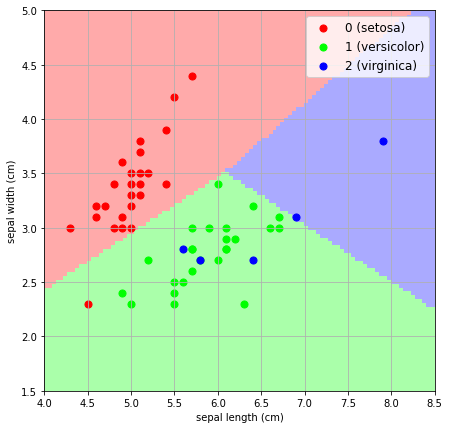

Training accuracy using data from region A: 0.9090909090909091
Validation accuracy using data from region A: 0.9272727272727272


In [11]:
log_reg_classifier_A = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
log_reg_classifier_A.fit(x_train_A, y_train_A)

# Here we obtain and print the confusion matrices for the logistic regression classifier trained with data from region A
train_confusion_matrix_A = confusion_matrix(y_true=y_train_A, y_pred=log_reg_classifier_A.predict(x_train_A))
train_confusion_matrix_normalised_A = train_confusion_matrix_A.astype('float') / train_confusion_matrix_A.sum(axis=1)[:, np.newaxis]

val_confusion_matrix_A = confusion_matrix(y_true=y_val_A, y_pred=log_reg_classifier_A.predict(x_val_A))
val_confusion_matrix_normalised_A = val_confusion_matrix_A.astype('float') / val_confusion_matrix_A.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(train_confusion_matrix_A))
print('Validation confusion matrix:\n {}\n'.format(val_confusion_matrix_A))

print('Normalised training confusion matrix:\n {}\n'.format(train_confusion_matrix_normalised_A))
print('Normalised validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised_A))



# Here we plot the validation dataset together with the decision regions
yPred_A = log_reg_classifier_A.predict(np.c_[x1_mesh.ravel(), x2_mesh.ravel()])
yPred_A = yPred_A.reshape(x2_mesh.shape)

plt.figure(figsize=(7, 7))
plt.pcolormesh(x1_mesh, x2_mesh, yPred_A, cmap=cmap_light)

scatter = plt.scatter(x_val_A[y_val_A==0,0], x_val_A[y_val_A==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, iris.target_names[0]))
scatter = plt.scatter(x_val_A[y_val_A==1,0], x_val_A[y_val_A==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, iris.target_names[1]))
scatter = plt.scatter(x_val_A[y_val_A==2,0], x_val_A[y_val_A==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, iris.target_names[2]))
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend(fontsize=12)
plt.xlim(4,8.5)
plt.ylim(1.5,5)
plt.grid(True)
plt.show()

print('Training accuracy using data from region A: {}'.format(log_reg_classifier_A.score(x_train_A, y_train_A)))
print('Validation accuracy using data from region A: {}'.format(log_reg_classifier_A.score(x_val_A, y_val_A)))



The accuracy of the logistic regression classifier trained and validated on the datasets extracted from region A is higher than the classifier trained and validated on the original datasets. Does it mean that one classifier is better than the other? The answer is that it makes no sense to compare both classifiers, as they have been created for **different target populations** (the original one and the population from region A).

The confusion matrices show that even though the overall accuracy is around 0.9, virginica (label 2) samples are being heavily misclassified: 60% of the virginica species are wrongly classified as versicolor. The reason is that our classifier is trying to obtain the highest overall accuracy regardless of the class, and the minority class has ended up being sacrified for this overall goal.  

Let's plot the decision regions defining the original and region A classifiers together with their training datasets:

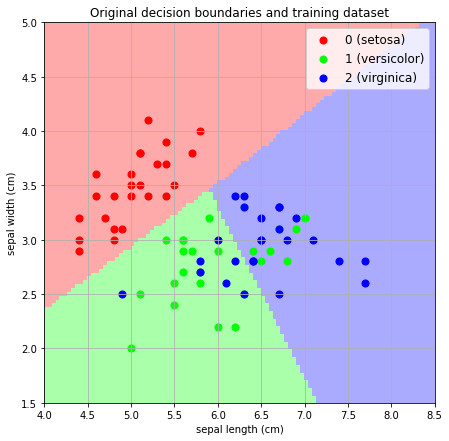

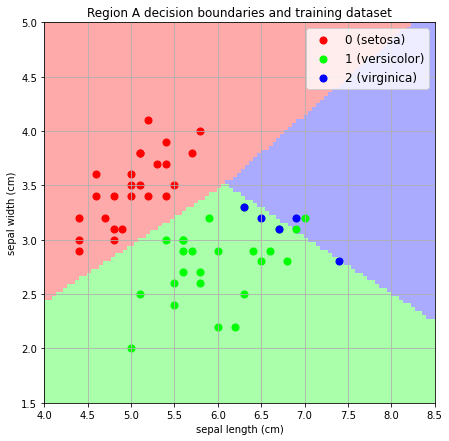

In [12]:
# Plot original decision boundaries
plt.figure(figsize=(7, 7))
plt.pcolormesh(x1_mesh, x2_mesh, yPred, cmap=cmap_light)
scatter = plt.scatter(x_train[y_train==0,0], x_train[y_train==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, iris.target_names[0]))
scatter = plt.scatter(x_train[y_train==1,0], x_train[y_train==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, iris.target_names[1]))
scatter = plt.scatter(x_train[y_train==2,0], x_train[y_train==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, iris.target_names[2]))
plt.title('Original decision boundaries and training dataset')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend(fontsize=12)
plt.xlim(4,8.5)
plt.ylim(1.5,5)
plt.grid(True)

# Plot decision boundaries for region A
plt.figure(figsize=(7, 7))
plt.pcolormesh(x1_mesh, x2_mesh, yPred_A, cmap=cmap_light)
scatter = plt.scatter(x_train_A[y_train_A==0,0], x_train_A[y_train_A==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, iris.target_names[0]))
scatter = plt.scatter(x_train_A[y_train_A==1,0], x_train_A[y_train_A==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, iris.target_names[1]))
scatter = plt.scatter(x_train_A[y_train_A==2,0], x_train_A[y_train_A==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, iris.target_names[2]))
plt.title('Region A decision boundaries and training dataset')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend(fontsize=12)
plt.xlim(4,8.5)
plt.ylim(1.5,5)
plt.grid(True)


plt.show()




The main difference between both classifiers is the location of the boundary separating versicolor (label 1) and virginica (label 2) species. Concretly, the classifier trained on samples from region A has moved the boundary further up. One way to understand this is to imagine samples pushing the boundary away from them. In the original dataset there were 25 samples from each class, so the final boundary ended up in the middle (look at the original confusion matrices to see how many samples from each class where misclassified). In the region A dataset there are only 5 virginica samples, hence the versicolor samples managed to move the boundary further in their favour.

Let's carry out one final experiment. We will use the original logistic regression classifier on the validation dataset extracted from region A and vice versa. What do you think will happen?


Original classifier, validation data from A:
 Confusion matrix 
 [[24  1  0]
 [ 0 20  5]
 [ 0  2  3]]
 
Accuracy: 0.8545454545454545



Classifier trained on data from A, original validation data:
 Confusion matrix 
 [[24  1  0]
 [ 0 20  5]
 [ 0  2  3]]
 
Accuracy: 0.8


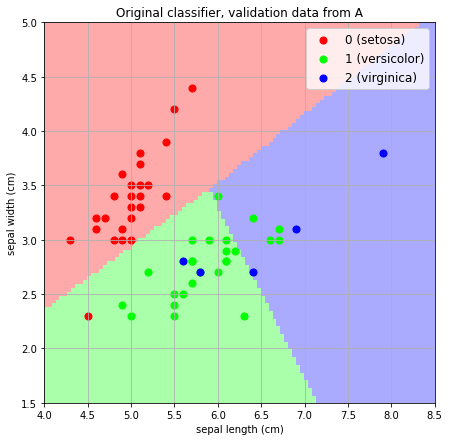

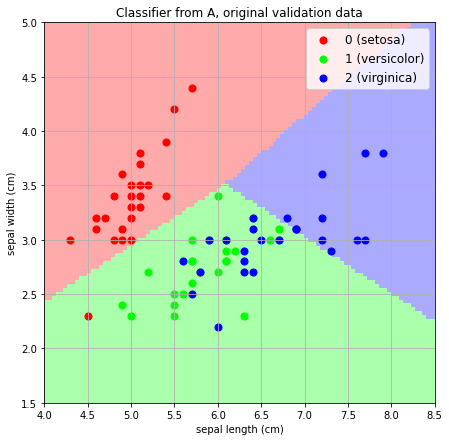

In [13]:

# Here we obtain and print the confusion matrices for the logistic regression classifier trained with data from region A

val_confusion_matrix_original_A = confusion_matrix(y_true=y_val_A, y_pred=log_reg_classifier.predict(x_val_A))
val_confusion_matrix_A_original = confusion_matrix(y_true=y_val, y_pred=log_reg_classifier_A.predict(x_val))

print('Original classifier, validation data from A:\n Confusion matrix \n {}\n'.format(val_confusion_matrix_original_A), '\nAccuracy: {}'.format(log_reg_classifier.score(x_val_A, y_val_A)))

print('\n\n')

print('Classifier trained on data from A, original validation data:\n Confusion matrix \n {}\n'.format(val_confusion_matrix_original_A), '\nAccuracy: {}'.format(log_reg_classifier_A.score(x_val, y_val)))



# Plot original decision boundaries and A validation data
plt.figure(figsize=(7, 7))
plt.pcolormesh(x1_mesh, x2_mesh, yPred, cmap=cmap_light)
scatter = plt.scatter(x_val_A[y_val_A==0,0], x_val_A[y_val_A==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, iris.target_names[0]))
scatter = plt.scatter(x_val_A[y_val_A==1,0], x_val_A[y_val_A==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, iris.target_names[1]))
scatter = plt.scatter(x_val_A[y_val_A==2,0], x_val_A[y_val_A==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, iris.target_names[2]))
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.title("Original classifier, validation data from A")
plt.legend(fontsize=12)
plt.xlim(4,8.5)
plt.ylim(1.5,5)
plt.grid(True)

# Plot decision boundaries for region A and original validation data
plt.figure(figsize=(7, 7))
plt.pcolormesh(x1_mesh, x2_mesh, yPred_A, cmap=cmap_light)
scatter = plt.scatter(x_val[y_val==0,0], x_val[y_val==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, iris.target_names[0]))
scatter = plt.scatter(x_val[y_val==1,0], x_val[y_val==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, iris.target_names[1]))
scatter = plt.scatter(x_val[y_val==2,0], x_val[y_val==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, iris.target_names[2]))
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.title("Classifier from A, original validation data")
plt.legend(fontsize=12)
plt.xlim(4,8.5)
plt.ylim(1.5,5)
plt.grid(True)


As you can see, the accuracy of both classifiers is lower when validated on data from a different population.

We have explored how boundaries change when we move from a balanced to an imbalanced scenario. It is tempting to feel the imbalanced scenario is "not fair" and you might think that the right thing to do is to re-balance the dataset. However this is not quite the point. The main point is to choose a suitable metric that reflects our goals. If the overall accuracy is what matters, the minority class will always be disadvantaged. If "class-fairness" is important, then we have a different notion of quality in mind.

# The Bayesian perspective

Logistic regression and kNN can be seen as two classification methods that build posterior probabilities and proceed to assign samples to the class with the **highest posterior probability**.

Bayes rule shows that we can build posterior probabilities using the **priors** for each class and the **class densities**. Note that some textbooks refer to the class densities as the **likelihood** of the predictors given a class. We prefer to use the term class density.

Distinguishing between priors and class densities can be very useful, as they reflect different aspects of our data. When we were exploring balanced and imbalanced datasets, we got an idea of the role of our class priors, as they quantify how numerous each class is. For instance in the original Iris dataset, the priors for each class are 1/3, 1/3 and 1/3. The class densities tell us which feature values we should expect if we are given a flower from one of the species.

In the previous section we concluded that using a classifier on a population different from the one where we extracted our data from will always result in lower accuracies. However, do we really need to always retrain our models from scratch? After all, setosa flowers are the same irrespective of where in the world they are. Can we somehow reuse our classifiers? 

As we will see in this section, separating posterior probabilities into priors and class densities will allow us to adjust classifiers when the populations where the training and validation datasets come from are different. The trick is to essentially keep the class densities and update the priors. Very simple.


Let's import a **Naive Bayes classifier** from scikit-learn. A Naive Bayes classifier builds posterior probabilities by decomposing them into priors and class densities and assumes that the class densities are Gaussian, just like discriminant analysis. There is one additional restriction on the Gaussian class densities, which will be discussed when we study unsupervised learning. For now, let's just say the class densities are Gaussian.  

Training confusion matrix:
 [[25  0  0]
 [ 0 22  3]
 [ 0  2  3]]

Validation confusion matrix:
 [[24  1  0]
 [ 0 23  2]
 [ 0  4  1]]

Normalised training confusion matrix:
 [[1.   0.   0.  ]
 [0.   0.88 0.12]
 [0.   0.4  0.6 ]]

Normalised validation confusion matrix:
 [[0.96 0.04 0.  ]
 [0.   0.92 0.08]
 [0.   0.8  0.2 ]]



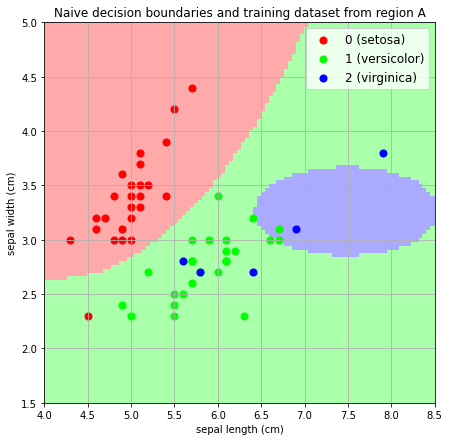

Training accuracy : 0.9090909090909091
Validation accuracy : 0.8727272727272727


In [14]:
from sklearn.naive_bayes import GaussianNB
gnb_A = GaussianNB()
gnb_A.fit(x_train_A, y_train_A)

# Here we obtain and print the confusion matrices for the logistic regression classifier trained with data from region A
train_confusion_matrix_naive_A = confusion_matrix(y_true=y_train_A, y_pred=gnb_A.predict(x_train_A))
train_confusion_matrix_normalised_naive_A = train_confusion_matrix_naive_A.astype('float') / train_confusion_matrix_naive_A.sum(axis=1)[:, np.newaxis]

val_confusion_matrix_naive_A = confusion_matrix(y_true=y_val_A, y_pred=gnb_A.predict(x_val_A))
val_confusion_matrix_normalised_naive_A = val_confusion_matrix_naive_A.astype('float') / val_confusion_matrix_naive_A.sum(axis=1)[:, np.newaxis]

print('Training confusion matrix:\n {}\n'.format(train_confusion_matrix_naive_A))
print('Validation confusion matrix:\n {}\n'.format(val_confusion_matrix_naive_A))

print('Normalised training confusion matrix:\n {}\n'.format(train_confusion_matrix_normalised_naive_A))
print('Normalised validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised_naive_A))


# Here we plot the validation dataset together with the decision regions
yPred_naive_A = gnb_A.predict(np.c_[x1_mesh.ravel(), x2_mesh.ravel()])
yPred_naive_A = yPred_naive_A.reshape(x2_mesh.shape)

plt.figure(figsize=(7, 7))
plt.pcolormesh(x1_mesh, x2_mesh, yPred_naive_A, cmap=cmap_light)

scatter = plt.scatter(x_val_A[y_val_A==0,0], x_val_A[y_val_A==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, iris.target_names[0]))
scatter = plt.scatter(x_val_A[y_val_A==1,0], x_val_A[y_val_A==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, iris.target_names[1]))
scatter = plt.scatter(x_val_A[y_val_A==2,0], x_val_A[y_val_A==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, iris.target_names[2]))
plt.title('Naive decision boundaries and training dataset from region A')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend(fontsize=12)
plt.xlim(4,8.5)
plt.ylim(1.5,5)
plt.grid(True)
plt.show()

print('Training accuracy : {}'.format(gnb_A.score(x_train_A, y_train_A)))
print('Validation accuracy : {}'.format(gnb_A.score(x_val_A, y_val_A)))


Let's now use the classifier trained on data from region A on the original validation data: 

Validation confusion matrix:
 [[24  1  0]
 [ 0 23  2]
 [ 0 15 10]]

Normalised validation confusion matrix:
 [[0.96 0.04 0.  ]
 [0.   0.92 0.08]
 [0.   0.6  0.4 ]]



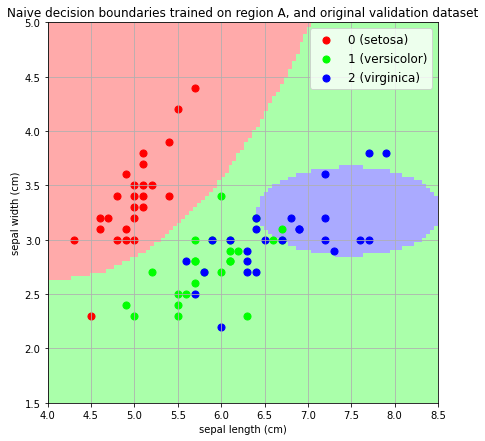

Validation accuracy : 0.76


In [15]:

# Here we obtain and print the confusion matrices for the logistic regression classifier trained with data from region A

val_confusion_matrix_naive_A = confusion_matrix(y_true=y_val, y_pred=gnb_A.predict(x_val))
val_confusion_matrix_normalised_naive_A = val_confusion_matrix_naive_A.astype('float') / val_confusion_matrix_naive_A.sum(axis=1)[:, np.newaxis]

print('Validation confusion matrix:\n {}\n'.format(val_confusion_matrix_naive_A))
print('Normalised validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised_naive_A))


# Here we plot the validation dataset together with the decision regions


yPred_naive_A = gnb_A.predict(np.c_[x1_mesh.ravel(), x2_mesh.ravel()])
yPred_naive_A = yPred_naive_A.reshape(x2_mesh.shape)

plt.figure(figsize=(7, 7))
plt.pcolormesh(x1_mesh, x2_mesh, yPred_naive_A, cmap=cmap_light)

scatter = plt.scatter(x_val[y_val==0,0], x_val[y_val==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, iris.target_names[0]))
scatter = plt.scatter(x_val[y_val==1,0], x_val[y_val==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, iris.target_names[1]))
scatter = plt.scatter(x_val[y_val==2,0], x_val[y_val==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, iris.target_names[2]))
plt.title('Naive decision boundaries trained on region A, and original validation dataset')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend(fontsize=12)
plt.xlim(4,8.5)
plt.ylim(1.5,5)
plt.grid(True)
plt.show()

print('Validation accuracy : {}'.format(gnb_A.score(x_val, y_val)))

As you can see, the performance is lower than the one obtained when using the validation dataset from region A. What if we use the priors from the original dataset?

Validation confusion matrix:
 [[24  1  0]
 [ 0 21  4]
 [ 0 12 13]]

Normalised validation confusion matrix:
 [[0.96 0.04 0.  ]
 [0.   0.84 0.16]
 [0.   2.4  2.6 ]]



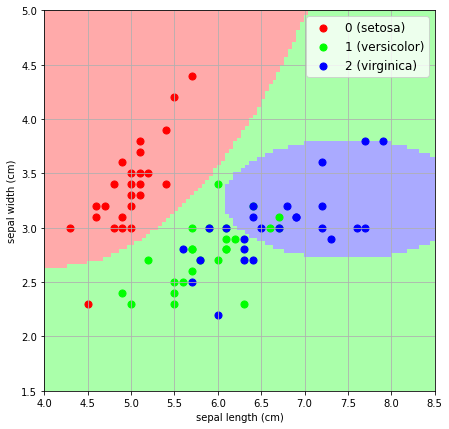

Validation accuracy : 0.7733333333333333


In [16]:
# Here we train a Naive Bayes model with the training data from region A, but impose the original priors
gnb_A_priors = GaussianNB(priors=np.array([1/3,1/3,1/3]))
gnb_A_priors.fit(x_train_A, y_train_A)

# Here we obtain and print the confusion matrices for the logistic regression classifier trained with data from region A

val_confusion_matrix_naive_A = confusion_matrix(y_true=y_val, y_pred=gnb_A_priors.predict(x_val))
val_confusion_matrix_normalised_naive_A = val_confusion_matrix_naive_A.astype('float') / val_confusion_matrix_A.sum(axis=1)[:, np.newaxis]

print('Validation confusion matrix:\n {}\n'.format(val_confusion_matrix_naive_A))
print('Normalised validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised_naive_A))


# Here we plot the validation dataset together with the decision regions


yPred_naive_A = gnb_A_priors.predict(np.c_[x1_mesh.ravel(), x2_mesh.ravel()])
yPred_naive_A = yPred_naive_A.reshape(x2_mesh.shape)

plt.figure(figsize=(7, 7))
plt.pcolormesh(x1_mesh, x2_mesh, yPred_naive_A, cmap=cmap_light)

scatter = plt.scatter(x_val[y_val==0,0], x_val[y_val==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, iris.target_names[0]))
scatter = plt.scatter(x_val[y_val==1,0], x_val[y_val==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, iris.target_names[1]))
scatter = plt.scatter(x_val[y_val==2,0], x_val[y_val==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, iris.target_names[2]))
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend(fontsize=12)
plt.xlim(4,8.5)
plt.ylim(1.5,5)
plt.grid(True)
plt.show()

print('Validation accuracy : {}'.format(gnb_A_priors.score(x_val, y_val)))

By using the priors of the population where the Naive Bayes model will be validated, we can adjust the decision boundaries and improve the overall accuracy. 

# Summary

In this lab, we have used a **multi-class** dataset to build **kNN** classifiers, **logistic regression** linear classifiers and **Naive Bayes** classifiers. Naive Bayes classifiers are similar to classifiers based on discriminant analysis in that they build posterior probabilities by applying **Bayes rule**.

We have obtained and analysed the **confusion matrices** and decision regions of all the models that we have trained. A confusion matrix is the first step towards understanding how our classifiers are treating each class separately, which is crucial in class-aware applications where the cost of misclassifying samples from different classes is different. Imbalanced datasets can result in minority classes to be heavily misclassified, hence it is important to be aware of these effects and to think carefully about the quality metric that we want to use.

**Class priors** quantify how balanced our datasets are. We have seen that Bayesian approaches, i.e. those that use the Bayes rule to create posterior probabilities, are a convenient way to adapt a classifier to a new dataset where the priors are different but the class densities remain the same. 

Whenever you feel ready, go ahead and attempt the 6th quizz.
